In [1]:
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import ppscore as pps
import datetime
import ppscore as pps
import random
from torchsummary import summary
import bokeh
from bokeh.plotting import figure, show
pd.set_option("display.max_columns",80)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.set_option("display.max_rows",80)
import tslumen
import tqdm as notebook_tqdm
import datetime as dt
from tslumen import HtmlReport
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tqdm as notebook_tqdm
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



c:\Users\nati\Desktop\Implementations\ImplementationsVenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


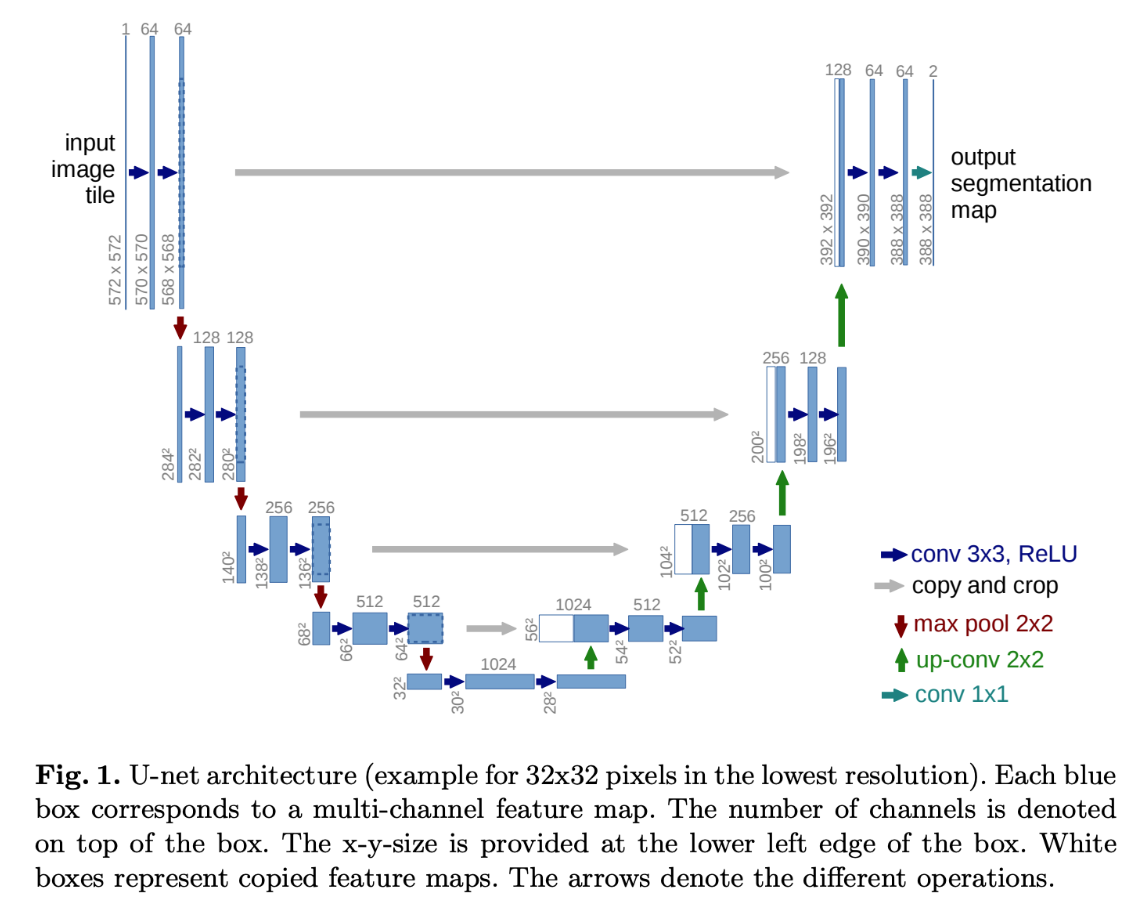

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [3]:
Unet = build_unet()
Unet.to(device)


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [4]:
summary(Unet, (3,512,512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        conv_block-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
     encoder_block-9  [[-1, 64, 512, 512], [-1, 64, 256, 256]]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14    